## Hueristic to improve preferred path for ancestor node

1. Adjust scoring history and use last score if the score does not improve.
2. Update nodes that are updated.
3. Change score calculation - include gap penalty.
4. Change data structure to include nodes and distance.
5. Adjust the markov chain to normalise the probbailty by number of edges skipped.

In [10]:
# libraries
from ete3 import Tree
from pysam import FastaFile
from scipy.spatial.distance import hamming
import re
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [2]:
def sequence_distance_score(str1,str2):
    dis = 0
    prev_dis = 0
    
    str1 =  re.sub('[a-zA-Z]', 'a', str1)
    str2 =  re.sub('[a-zA-Z]', 'a', str2)
    
    for i in range(0,len(str1)):
        if str1[i] != str2[i]:  # not matching
            if prev_dis == 0:   # previous unmatched
                dis += 3
                prev_dis = 1
            else:
                dis += 1
        else:
            prev_dis = 0
    return dis

print(sequence_distance_score('AAAAAAA','AAAAAAA'))
print(sequence_distance_score('_AAAAAA','AAAAAAA'))
print(sequence_distance_score('AAA__AA','AAAAAAA'))
print(sequence_distance_score('AA_A_AA','AAAAAAA'))


0
3
4
6


In [54]:
# class - to load tree, load sequences, neighbours, pogs, hamming distance, overall score for a given tree.

class PhyloTree:
    
    def __init__(self,nwk_file_path,ancestor_fasta_file,json_pogs_file):
        ''' initialise the PhyloTree Class '''
        tree_file = open(nwk_file_path,"r")
        my_tree = tree_file.read() + ";"
        self.tree = Tree(my_tree, format=1)
        self.patience = 500
        self.all_ancestor_nodes = []
        self.all_ancestor_pogs_path = []
        self.ancestor_fasta_file = ancestor_fasta_file
        self.json_pogs_file = json_pogs_file
        self.folder_to_save_numpy_arrays = '/'.join(self.json_pogs_file.split('/')[0:-1]) + '/'
        self.total_tree_score = 0
        self.nodes_changed_details = []
               
        
    def sequence_distance_score(self,str1,str2):
        ''' 2 sequence scoring formula '''
        
        # ignore amino acids
        str1 =  re.sub('[a-zA-Z]', 'a', str1)
        str2 =  re.sub('[a-zA-Z]', 'a', str2)
          
        dis = 0
        prev_dis = 0

        for i in range(0,len(str1)):
            if str1[i] != str2[i]:  # not matching
                if prev_dis == 0:   # previous unmatched
                    dis += 3
                    prev_dis = 1
                else:
                    dis += 1
            else:
                prev_dis = 0
        return dis
          
    def load_attributes(self):
        ''' load node attributes - sequences, neighbours, hamming distance '''
        sequences_info = FastaFile(self.ancestor_fasta_file)
        
        for n in self.tree.traverse():
            ancestor_nodes_info = {}
            current_node_sequence = sequences_info.fetch(n.name)
            sequence_simple       = re.sub('[a-zA-Z]', 'a', sequences_info.fetch(n.name))
                
            if n.is_leaf() == False:    
                # add node sequence on the tree
                
                neighbor_n_distance = {}
                child_n_distance = {}
                
                for c in n.children:
                    child_sequence = sequences_info.fetch(c.name)
                    distance_calc = self.sequence_distance_score(current_node_sequence,child_sequence)
                    neighbor_n_distance[c.name] = distance_calc
                    child_n_distance[c.name]    = distance_calc
                    
                if n.is_root() == False:
                    parent_sequence = sequences_info.fetch(n.up.name)
                    neighbor_n_distance[n.up.name] = self.sequence_distance_score(current_node_sequence,parent_sequence)
                    
            
            # assemble all information into 1 dictionary
            ancestor_nodes_info['name'] = n.name
            ancestor_nodes_info['sequence'] = sequence_simple
            ancestor_nodes_info['neighbor_n_distance'] = neighbor_n_distance
            ancestor_nodes_info['child_n_distance'] = child_n_distance
            self.all_ancestor_nodes.append(ancestor_nodes_info)
            
        #print(self.all_ancestor_nodes)
        
                
    def count_path(self,a):
        ''' count the number of paths in a graph '''
        a = a + a.T    #add up the transpose
        a = np.clip(a,0,1)
        a = np.triu(a) #only the upper triangle

        nodes = a.shape[0]
        dp = [0] * nodes
        dp[nodes - 1]= 1 #last node

        for i in range(nodes - 1, -1, -1):
            neighbour_nodes = np.where (a[i] == 1)[0]
            for j in neighbour_nodes:
                dp[i] = dp[i] + dp[j]

        return(dp[0])
        
    
    def paths_in_pogs_cnt(self):
        ''' total paths in the pogs for ancestor nodes '''
        ''' save pogs as numpy array '''
        
        total_sequences_list = []
        all_exp_results = []
        
        # read the json file
        with open(self.json_pogs_file, 'r') as j:
            pog_all_data = json.loads(j.read())

            # read all ancestors
            for node_type in ['Ancestors','Extants']:
                for pog_data in pog_all_data[node_type]:
                    
                    pog_path_dict = {}
                    
                    if node_type == 'Ancestors':
                        node_name = 'N' + pog_data['Name']
                    else:
                        node_name = pog_data['Name']
                    
                    pog_path_dict['name'] = node_name

                    # read that node's data
                    nodes = pog_data['Size'] + 2

                    # create numpy zero matrix
                    mat = np.zeros(shape=(nodes,nodes))

                    # Edges from special Start node to the start nodes
                    for s in pog_data['Starts']:
                        mat[0,s + 1] = 1

                    # Edges from last node to the special End node
                    for e in pog_data['Ends']:
                        mat[e + 1,nodes-1] = 1

                    # create the adjency matrix for all nodes except from special node start
                    for ind,node in enumerate(pog_data['Indices']):
                        row_mat = node
                        row_col = pog_data['Adjacent'][ind]

                        for rc in row_col:
                            mat[row_mat + 1,rc + 1] = 1
                        

                    # count the number of viable paths from the POG
                    total_sequences = self.count_path(mat)

                    pog_path_dict['total_paths'] = total_sequences

                    self.all_ancestor_pogs_path.append(pog_path_dict)

                    # save pogs as numpy array ( needed later for markov chain hueristic)

                    # convert bidirectional mat into unidirectional
                    mat = mat + mat.T     #add up the transpose
                    mat = np.clip(mat,0,1)
                    mat = np.triu(mat)   #only the upper triangle
                    
                    ## for testing
#                     if node_name == 'N155':
#                         for i in range(0,nodes):
#                             for j in range(0,nodes):
#                                 if mat[i][j] != 0:
#                                     print("Edge from node {} to node {} is. {}".format(i,j,mat[i][j]))


                    # save numpy array in file
                    mat_file_name = self.folder_to_save_numpy_arrays +  node_name + '.npy'
                    np.save(mat_file_name,mat)
                
        
    def weighted_nodes_model(self,node_to_improve,neighbor_list):
        ''' weighted model to find preferred path for a ancestor node.
            Each position in the sequence is a state in the markov chain model.'''
        
        total_states   = np.load(self.folder_to_save_numpy_arrays + neighbor_list[0] + '.npy').shape[0]    
        wt_model       = np.full((total_states, total_states),0)   
        
        # sum up the neighbor pog array
        for n in neighbor_list:
            m = np.load(self.folder_to_save_numpy_arrays + n + '.npy')
            wt_model = np.add(wt_model,m)

        print("All Neighbor POG")
        #self.translateModel(wt_model,0)
            
        # project the neighbour markov chain into the current node
        # if the path does not exists in the current node, change the value to 0
        current_node_np = np.load(self.folder_to_save_numpy_arrays + node_to_improve + '.npy')
#         print("N533 POG")
#         self.translateModel(current_node_np,0)
        
        # node not present will be wiped out
        wt_model = wt_model * current_node_np
#         self.translateModel(wt_model,0)
        
        # add the current node pog
        wt_model = wt_model + current_node_np
#         self.translateModel(wt_model,0)
        
        #print(self.translateModel(wt_model,0))
        
        # normalise the weights
        wt_model = wt_model / (len(neighbor_list) + 1)  # add 1 as current node is also considered
        
        
        # wherever it is 0, put a max weight, to avoid divide by 0 error
        wt_model[wt_model == 0] = -2
        
        # -log(weight) transformation
        wt_model = -1 * np.log(wt_model, out = wt_model, where = wt_model > -2)
        
        # replace 2 with 0 to indicate no path and add 1 for all others.
        wt_model = np.where(wt_model == 2,0, wt_model + 1)
        
#         if node_to_improve == 'N533':
#             np.save('wt_model.npy',wt_model)
        return wt_model
    
    
    def translateModel(self,wt_model,value_skip):
        total_nodes = wt_model.shape[0]
        
        for i in range(0,total_nodes):
           
            for j in range(0,total_nodes):
                if wt_model[i][j] != value_skip:
                    print("Distance from node {} to node {} is. {}".format(i,j,wt_model[i][j]))
        
    
    def minDistance(self,dist,sptSet,total_nodes):
        
        # Initialize minimum distance for next node
        min = 1e7
        
        # Search not nearest vertex not in the
        # shortest path tree
        for v in range(total_nodes):
            if dist[v] <= min and sptSet[v] == False:
                min = dist[v]
                min_index = v

        return min_index
    
    def djikstra_shortest_path(self,wg_model):
        
        total_nodes = wg_model.shape[0] # total nodes to traverse
        dist = [1e7] * total_nodes
        dist[0] = 0
        sptSet   = [False] * total_nodes
        previous = [False] * total_nodes
        previous[0] = 0
        
        for cout in range(total_nodes):
            u = self.minDistance(dist, sptSet,total_nodes)
            sptSet[u] = True
            for v in range(total_nodes):
                if (wg_model[u][v] > 0 and sptSet[v] == False and 
                dist[v] > dist[u] + wg_model[u][v]):
                    dist[v] = dist[u] + wg_model[u][v]
                    previous[v] = u
        
        
        
        #print('previous',previous)
        # find shortest path
        pf    = [0] * total_nodes       # preferred path
        pf[0] = 1                       # starting node is always traversed
        
        # start from last node and go backwards
        target = len(previous)-1
        last_node = target
        pf[last_node] = 1  
        
        while(last_node!=0):
            last_node = previous[last_node]
            pf[last_node] = 1
        
        pf = pf [1:-1] # return path except for the first and last path
        return pf

    
    def calculate_score(self,mc_output,node_to_improve,neighbor_list,current_score):
        
        # replace 1 by a and 0 by - for hamming distance calculation
        #print('mc_output',mc_output)
        mc_output_sequence = ['a' if item == 1 else '-' for item in mc_output] 
        mc_output_sequence = ''.join(mc_output_sequence)
        
        # current node row
        node_df_info           = self.combined_df[self.combined_df['name'] == node_to_improve]
        current_indel_distance = float(node_df_info['avg_indel_distance'].to_string(index=False))
        current_sequence       = node_df_info['sequence'].to_string(index=False)
        
        # recalculate current node avg indel distance w.r.t neighbors
        node_avg_indel_distance  = 0
        node_child_n_distance    = {}
        node_neighbor_n_distance = {}
            
        for n in neighbor_list: 
            neighbor_sequence = self.combined_df[self.combined_df['name'] == \
                                              n]['sequence'].to_string(index=False)
            distance_calc = self.sequence_distance_score(mc_output_sequence,neighbor_sequence)
            node_avg_indel_distance += distance_calc
            node_neighbor_n_distance[n]  = distance_calc
            
            # check if present in child
            if n in node_df_info['child_n_distance'].values[0]:
                node_child_n_distance[n] = distance_calc
            
        node_avg_indel_distance = node_avg_indel_distance / len(neighbor_list) 
        
        print("BEFORE AVERAGE INDEL DISTANCE::",current_indel_distance)
        print("NEW AVERAGE INDEL DISTANCE::"   ,node_avg_indel_distance)
            
        # compare the scores
        if round(node_avg_indel_distance,4) < round(current_indel_distance,4): # recalculate neigh distance again
            
            print('NEW INDEL DISTANCE IS LESS THAN THE CURRENT INDEL DISTANCE')
            
            #print("BEFORE SEQUENCE:",current_sequence)
            #print("AFTER SEQUENCE:" ,mc_output_sequence)
            
            if self.sequence_distance_score(current_sequence,mc_output_sequence) == 0:
                print("ERROR:: BEFORE AND AFTER SEQUENCE ARE THE SAME.")
            
            # update the new sequence for the node
            self.combined_df.loc[self.combined_df['name'] == node_to_improve,'sequence']\
                                        = mc_output_sequence
            
            # update the current node information in dataframe
            self.combined_df.loc[self.combined_df['name'] == node_to_improve,'neighbor_n_distance']\
                                            = [node_neighbor_n_distance]
            self.combined_df.loc[self.combined_df['name'] == node_to_improve,'child_n_distance']\
                                            = [node_child_n_distance]
            
            # update the neighboring node information in dataframe
            for n in neighbor_list:
                n_neighbor_n_distance = self.combined_df[self.combined_df['name'] == n]\
                                            ['neighbor_n_distance'].values[0]
                n_neighbor_n_distance[node_to_improve] = node_neighbor_n_distance[n]
                self.combined_df.loc[self.combined_df['name'] == n,'neighbor_n_distance']\
                                            = [n_neighbor_n_distance]               
                
                # check if present in child
                n_child_n_distance = self.combined_df[self.combined_df['name'] == n]\
                                            ['child_n_distance'].values[0]
                if node_to_improve in n_child_n_distance:
                    n_child_n_distance[node_to_improve] = node_neighbor_n_distance[n]
                    self.combined_df.loc[self.combined_df['name'] == n,'child_n_distance']\
                                            = [n_child_n_distance]
                
        
            
            # rerun the distance calculation again
            self.score_nodes()
            
            # new score
            score = self.combined_df['total_child_distance'].sum()
            score_improve_flag = 1
            
            # store the changes made, so can be used for visualisation
            
            node_change_detailed_tuple = self.position_diff(current_sequence,mc_output_sequence,node_to_improve)
            self.nodes_changed_details.append(node_change_detailed_tuple)
            
        else:
            score = current_score
            score_improve_flag = 0
        
        # marked node as visited
        self.combined_df.loc[self.combined_df['name'] == node_to_improve, 'visited'] = True
            
        return score,score_improve_flag
        
    
    def position_diff(self,str1,str2,node_to_improve):
        ''' position by psoition differece'''
        ret_tuple = [node_to_improve]
        # ignore amino acids
        str1 =  re.sub('[a-zA-Z]', 'a', str1)
        str2 =  re.sub('[a-zA-Z]', 'a', str2)
         

        for i in range(0,len(str1)):
            if str1[i] != str2[i]:  # not matching
                if str1[i] == 'a':
                    ret_tuple.append(-1)  # deletion
                else:
                    ret_tuple.append(1)  # insertion
            else:
                ret_tuple.append(0)
                
        return tuple(ret_tuple)
        
    
    def markov_chain_neighbor(self,node_to_improve,neighbor_list,current_score):
        ''' markov chain method to find preferred path '''       
        
        # DJIKSTRA MODEL - GRASP PAPER
        wg_model  = self.weighted_nodes_model(node_to_improve,neighbor_list)
#         if node_to_improve == 'N533':
#             self.translateModel(wg_model,0)
 
        # perform inference
        wg_output = self.djikstra_shortest_path(wg_model)
#         if node_to_improve == 'N533':
#             print("dj wg_output",wg_output)
        
        # evaluate score
        new_score,score_improve_flag = self.calculate_score(wg_output,node_to_improve,neighbor_list,current_score)
        
        return score_improve_flag,new_score
        
    
    def score_visual(self,score_history):
        ''' visualise score improvement '''
        plt.plot(*zip(*score_history))
        plt.title('SCORE IMPROVEMENT HISTORY')
        plt.xlabel('ITERATION')
        plt.ylabel('TREE - INDEL PARSIMONY SCORE')
        plt.show()
        
    
    def visualise_changed_nodes(self):
        
        if len(self.nodes_changed_details) > 0 :
            sns.set(rc = {'figure.figsize':(50,20)})

            # Create an array with the colors you want to use
            colors = ["#FF0000", "#F5F5F5","#00FF00"]
            total_nodes = len(self.nodes_changed_details[0]) - 1
            columns_df = ['Node'] + list(range(1,total_nodes+1))
            amino_acid_pd = pd.DataFrame(self.nodes_changed_details,columns = columns_df)
            display(amino_acid_pd.head())
            amino_acid_pd.set_index('Node',inplace=True)

            ax = sns.heatmap(amino_acid_pd,center=0,vmin = -1, vmax = 1, cmap=colors)
            colorbar = ax.collections[0].colorbar
            colorbar.set_ticks([-0.75,0,0.75])
            colorbar.set_ticklabels(['DELETE','SAME','INSERT'])
        else:
            print("NO NODES CHANGED")
         
      
    def score_nodes(self):
        ''' calculate the avg indel distance and total child distance '''
        self.combined_df['avg_indel_distance']   =  self.combined_df['neighbor_n_distance'].\
                                                    apply(lambda x: sum(dict(x).values()) / (len(dict(x))) )
        self.combined_df['total_child_distance'] =  self.combined_df['child_n_distance'].\
                                                    apply(lambda x: sum(dict(x).values()))
                
    def hueristic_preferred_path(self):
        ''' hueristic algorithm to improve the overall tree score by selecting alternative preferred path '''
        
        
        start = time.time()
        
        # 1 - create a combined dataframe
        self.combined_df = pd.merge(pd.DataFrame(self.all_ancestor_nodes),\
                                pd.DataFrame(self.all_ancestor_pogs_path),how='left')
        
        
        # 2.1 - add nodes with only 1 path in the visited nodes list
        self.combined_df['visited'] = self.combined_df['total_paths'] == 1
        #self.combined_df['visited'] = 1
        #self.combined_df.loc[self.combined_df['name'] == 'N533','visited'] = 0
        
        
        # 2.2 - mark all nodes are not improved
        self.combined_df['improved'] = 0
        
        # 2.3 - calculate avg indel distance and neighbor distance
        self.score_nodes()
        
        # 3 - add rank for the nodes based on distance from neighbors
        self.combined_df['rank_pathcnts'] = self.combined_df['total_paths'].rank()
        self.combined_df['rank_distance'] = self.combined_df['avg_indel_distance'].rank()
        self.combined_df['total_rank']    = self.combined_df['rank_distance'] + self.combined_df['rank_pathcnts'] 
        pd.set_option('display.max_colwidth', None)
        display(self.combined_df[self.combined_df['name']=='N533'])
        
        # 4 - parameters for hueristic
        total_iterations      = sum(self.combined_df['visited'] == False)
        score_not_improve_cnt = 0
        score_track           = []
        current_score = self.combined_df['total_child_distance'].sum()
        score_track.append((0,current_score))
        print("TOTAL POTENTIAL NODES FOR IMPROVEMENT::",total_iterations)
        
        # 5 - hueristic loop
        for i in range(1,total_iterations+1):
            
            print("ITERATION::",i)
            current_score = self.combined_df['total_child_distance'].sum()
            print("CURRENT SCORE::", current_score)
            
            # pick node with max rank and which has not been visited
            df_filtered = self.combined_df[self.combined_df['visited'] == False].reset_index()    
            max_df_row  = df_filtered.iloc[df_filtered['total_rank'].idxmax()]
            node_to_improve = max_df_row['name']            
            node_neighbors = self.combined_df[self.combined_df['name'] == \
                                            node_to_improve]['neighbor_n_distance'].\
                                            apply(lambda x: list(dict(x).keys())).values[0]
            print("NODE SELECTED FOR IMPROVEMENT::",node_to_improve)
            print('NEIGHBOURS::',node_neighbors)
            
            # improve indel score here by choosing alternate path
            score_improve_flag,new_score = self.markov_chain_neighbor(node_to_improve,node_neighbors,current_score)
            
            
            if score_improve_flag == 1:
                print("SCORE IMPROVED FROM:{} TO {}".format(current_score,new_score))
                # update node as improved
                self.combined_df.loc[self.combined_df['name']== node_to_improve,'improved'] = 1
                score_not_improve_cnt = 0 # reset counter 
            else:
                print("SCORE DID NOT IMPROVE")
                score_not_improve_cnt += 1 # update the consecutive score improvement
            
            if score_not_improve_cnt >= self.patience:
                print("EXITING AS SCORE DID NOT IMROVE FOR LAST {} ITERATIONS".format(self.patience))
                break
            
            # track score
            score_track.append((i,new_score))
        print("TOTAL NODES IMPROVED::",sum(self.combined_df['improved']))
        end = time.time()
        
        print("TOTAL TIME TO RUN::",end - start)
        return score_track            

In [58]:
# input files for the algorithm

# ## sample tree
# nwk_file_path       = '/Users/sanjanatule/Documents/uq/Projects/PreferredPath/data/sample_tree/grasp_ancestors.nwk'
# ancestor_fasta_file = "/Users/sanjanatule/Documents/uq/Projects/PreferredPath/data/sample_tree/grasp_ancestors.fa"
# pogs_file           = '/Users/sanjanatule/Documents/uq/Projects/PreferredPath/data/sample_tree/pogs.json'

## CYP2U - 165
# nwk_file_path       = '/Users/sanjanatule/Documents/uq/Projects/PreferredPath/data/CYP2U_165/grasp_ancestors.nwk'
# ancestor_fasta_file = "/Users/sanjanatule/Documents/uq/Projects/PreferredPath/data/CYP2U_165/grasp_ancestors.fa"
# pogs_file           = '/Users/sanjanatule/Documents/uq/Projects/PreferredPath/data/CYP2U_165/pogs.json'

# ## CYP2U - 359
nwk_file_path       = '/Users/sanjanatule/Documents/uq/Projects/PreferredPath/data/CYP2U_359/grasp_ancestors.nwk'
ancestor_fasta_file = "/Users/sanjanatule/Documents/uq/Projects/PreferredPath/data/CYP2U_359/grasp_ancestors.fa"
pogs_file           = '/Users/sanjanatule/Documents/uq/Projects/PreferredPath/data/CYP2U_359/pogs.json'

# ## CYP2U - 595
# nwk_file_path       = '/Users/sanjanatule/Documents/uq/Projects/PreferredPath/data/CYP2U_595/grasp_ancestors.nwk'
# ancestor_fasta_file = "/Users/sanjanatule/Documents/uq/Projects/PreferredPath/data/CYP2U_595/grasp_ancestors.fa"
# pogs_file           = '/Users/sanjanatule/Documents/uq/Projects/PreferredPath/data/CYP2U_595/pogs.json'


# ## DHAD - 585
# nwk_file_path       = '/Users/sanjanatule/Documents/uq/Projects/PreferredPath/data/DHAD_585/grasp_ancestors.nwk'
# ancestor_fasta_file = "/Users/sanjanatule/Documents/uq/Projects/PreferredPath/data/DHAD_585/grasp_ancestors.fa"
# pogs_file           = '/Users/sanjanatule/Documents/uq/Projects/PreferredPath/data/DHAD_585/pogs.json'


### another sample tree
# nwk_file_path       = '/Users/sanjanatule/Documents/uq/Projects/PreferredPath/data/grasp_ancestors.nwk'
# ancestor_fasta_file = "/Users/sanjanatule/Documents/uq/Projects/PreferredPath/data/grasp_ancestors.fa"
# pogs_file           = '/Users/sanjanatule/Documents/uq/Projects/PreferredPath/data/pogs.json'


# hueristic steps
asrtree = PhyloTree(nwk_file_path,ancestor_fasta_file,pogs_file)
asrtree.load_attributes ()
asrtree.paths_in_pogs_cnt()
score_history = asrtree.hueristic_preferred_path()


,name,sequence,neighbor_n_distance,child_n_distance,total_paths,visited,improved,avg_indel_distance,total_child_distance,rank_pathcnts,rank_distance,total_rank


TOTAL POTENTIAL NODES FOR IMPROVEMENT:: 23
ITERATION:: 1
CURRENT SCORE:: 3597
NODE SELECTED FOR IMPROVEMENT:: N8
NEIGHBOURS:: ['XP_020652021.1', 'XP_003226556.2', 'N7']
All Neighbor POG
BEFORE AVERAGE INDEL DISTANCE:: 25.0
NEW AVERAGE INDEL DISTANCE:: 25.0
SCORE DID NOT IMPROVE
ITERATION:: 2
CURRENT SCORE:: 3597
NODE SELECTED FOR IMPROVEMENT:: N20
NEIGHBOURS:: ['XP_009900551.1', 'KFV68671.1', 'N19']
All Neighbor POG
BEFORE AVERAGE INDEL DISTANCE:: 15.666667
NEW AVERAGE INDEL DISTANCE:: 15.666666666666666
SCORE DID NOT IMPROVE
ITERATION:: 3
CURRENT SCORE:: 3597
NODE SELECTED FOR IMPROVEMENT:: N0
NEIGHBOURS:: ['N1', 'N165']
All Neighbor POG
BEFORE AVERAGE INDEL DISTANCE:: 12.0
NEW AVERAGE INDEL DISTANCE:: 12.0
SCORE DID NOT IMPROVE
ITERATION:: 4
CURRENT SCORE:: 3597
NODE SELECTED FOR IMPROVEMENT:: N121
NEIGHBOURS:: ['XP_006629927.2', 'N122', 'N2']
All Neighbor POG
BEFORE AVERAGE INDEL DISTANCE:: 10.666667
NEW AVERAGE INDEL DISTANCE:: 13.666666666666666
SCORE DID NOT IMPROVE
ITERATION:: 5

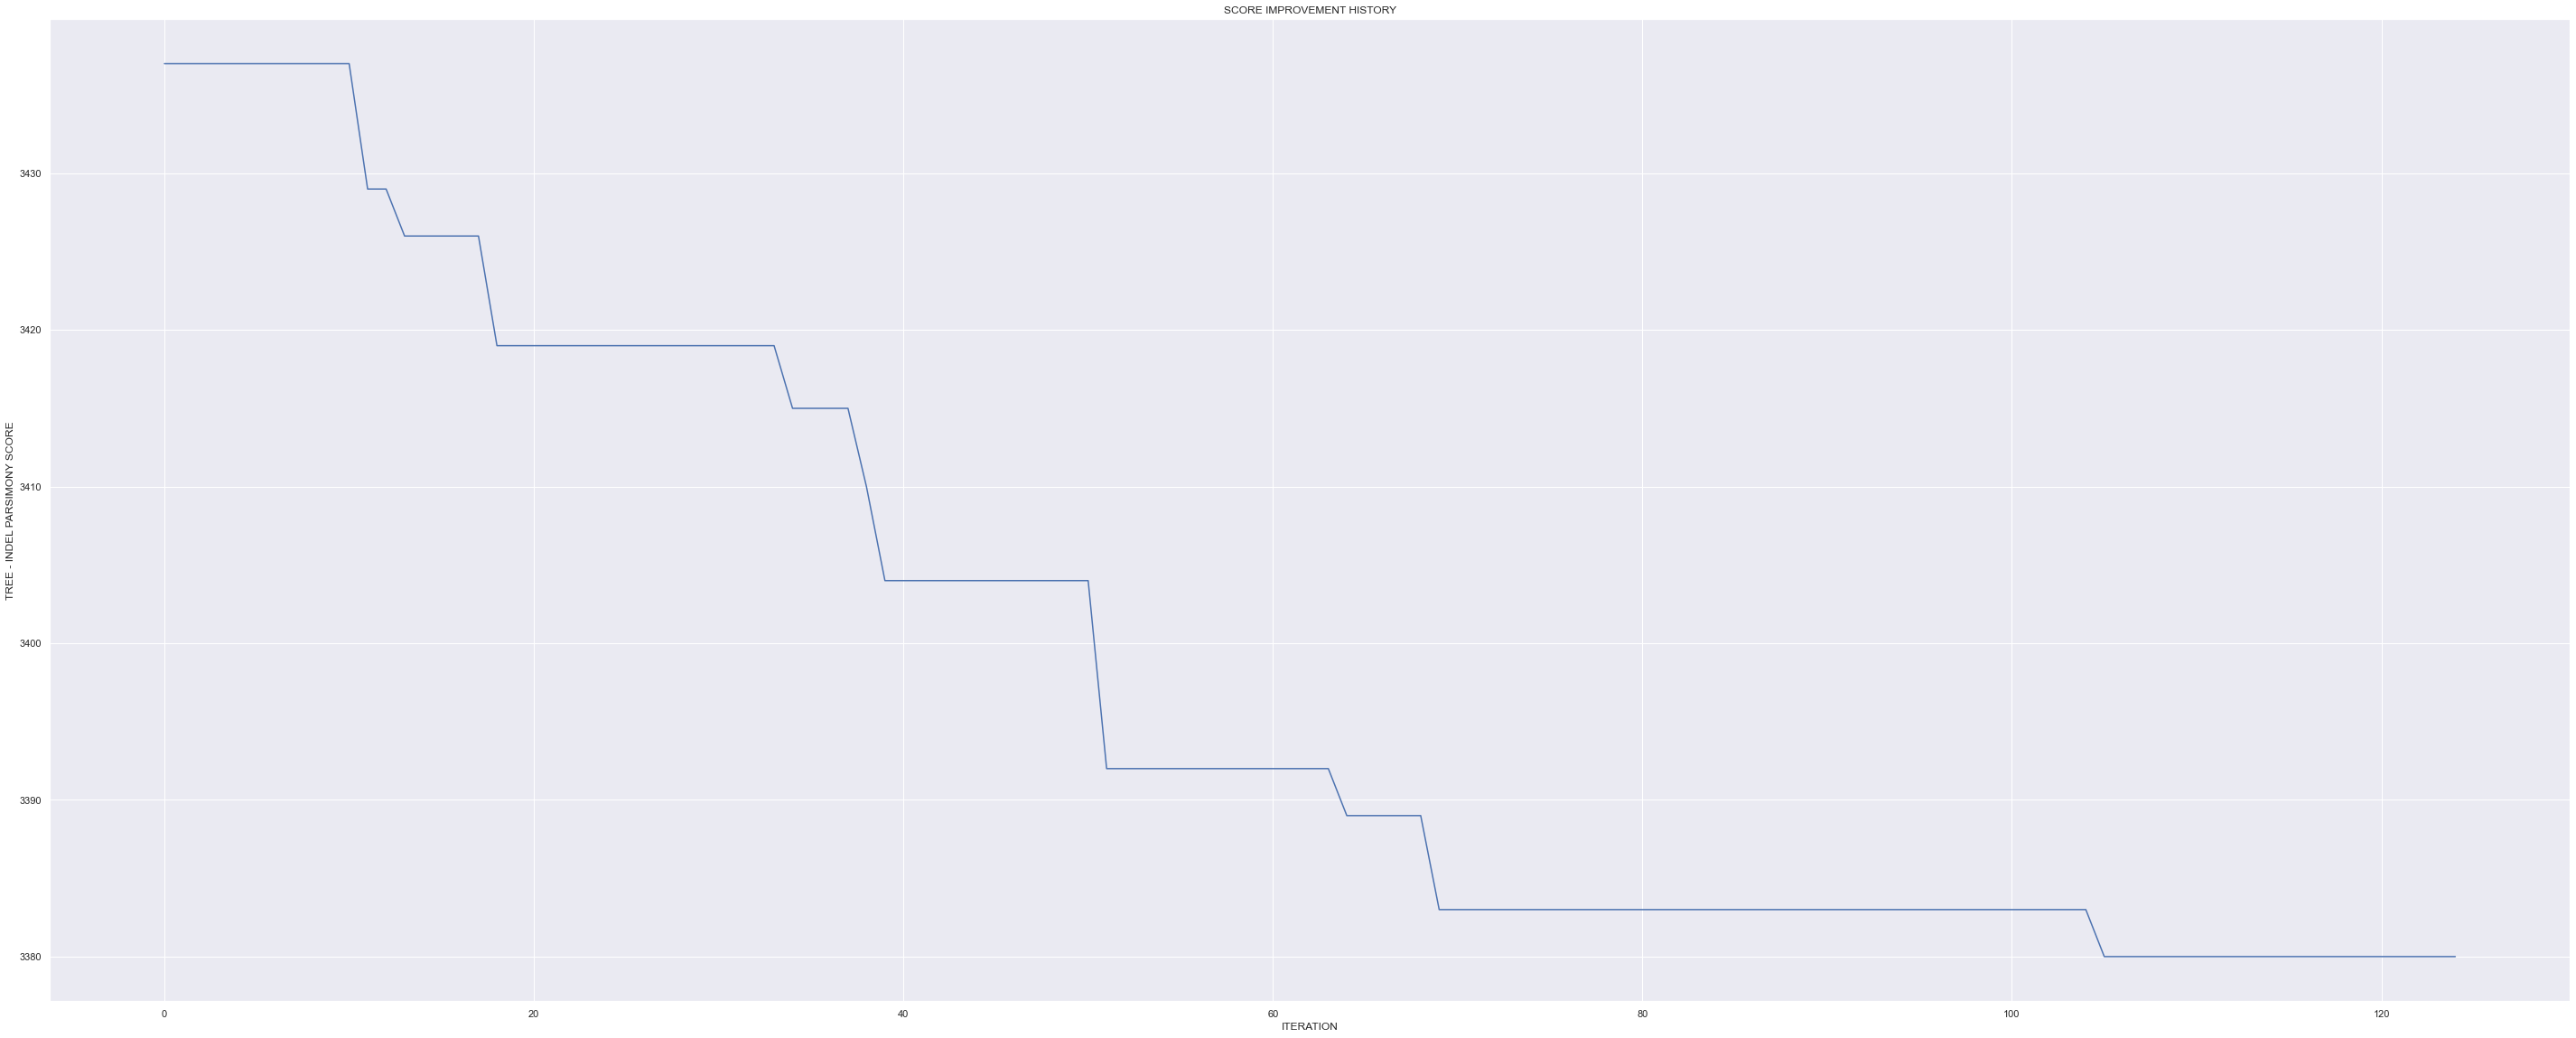

In [56]:
asrtree.score_visual(score_history)

,Node,1,2,3,4,5,6,7,8,9,...,765,766,767,768,769,770,771,772,773,774
0,N548,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,N424,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,N561,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,N157,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,N520,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


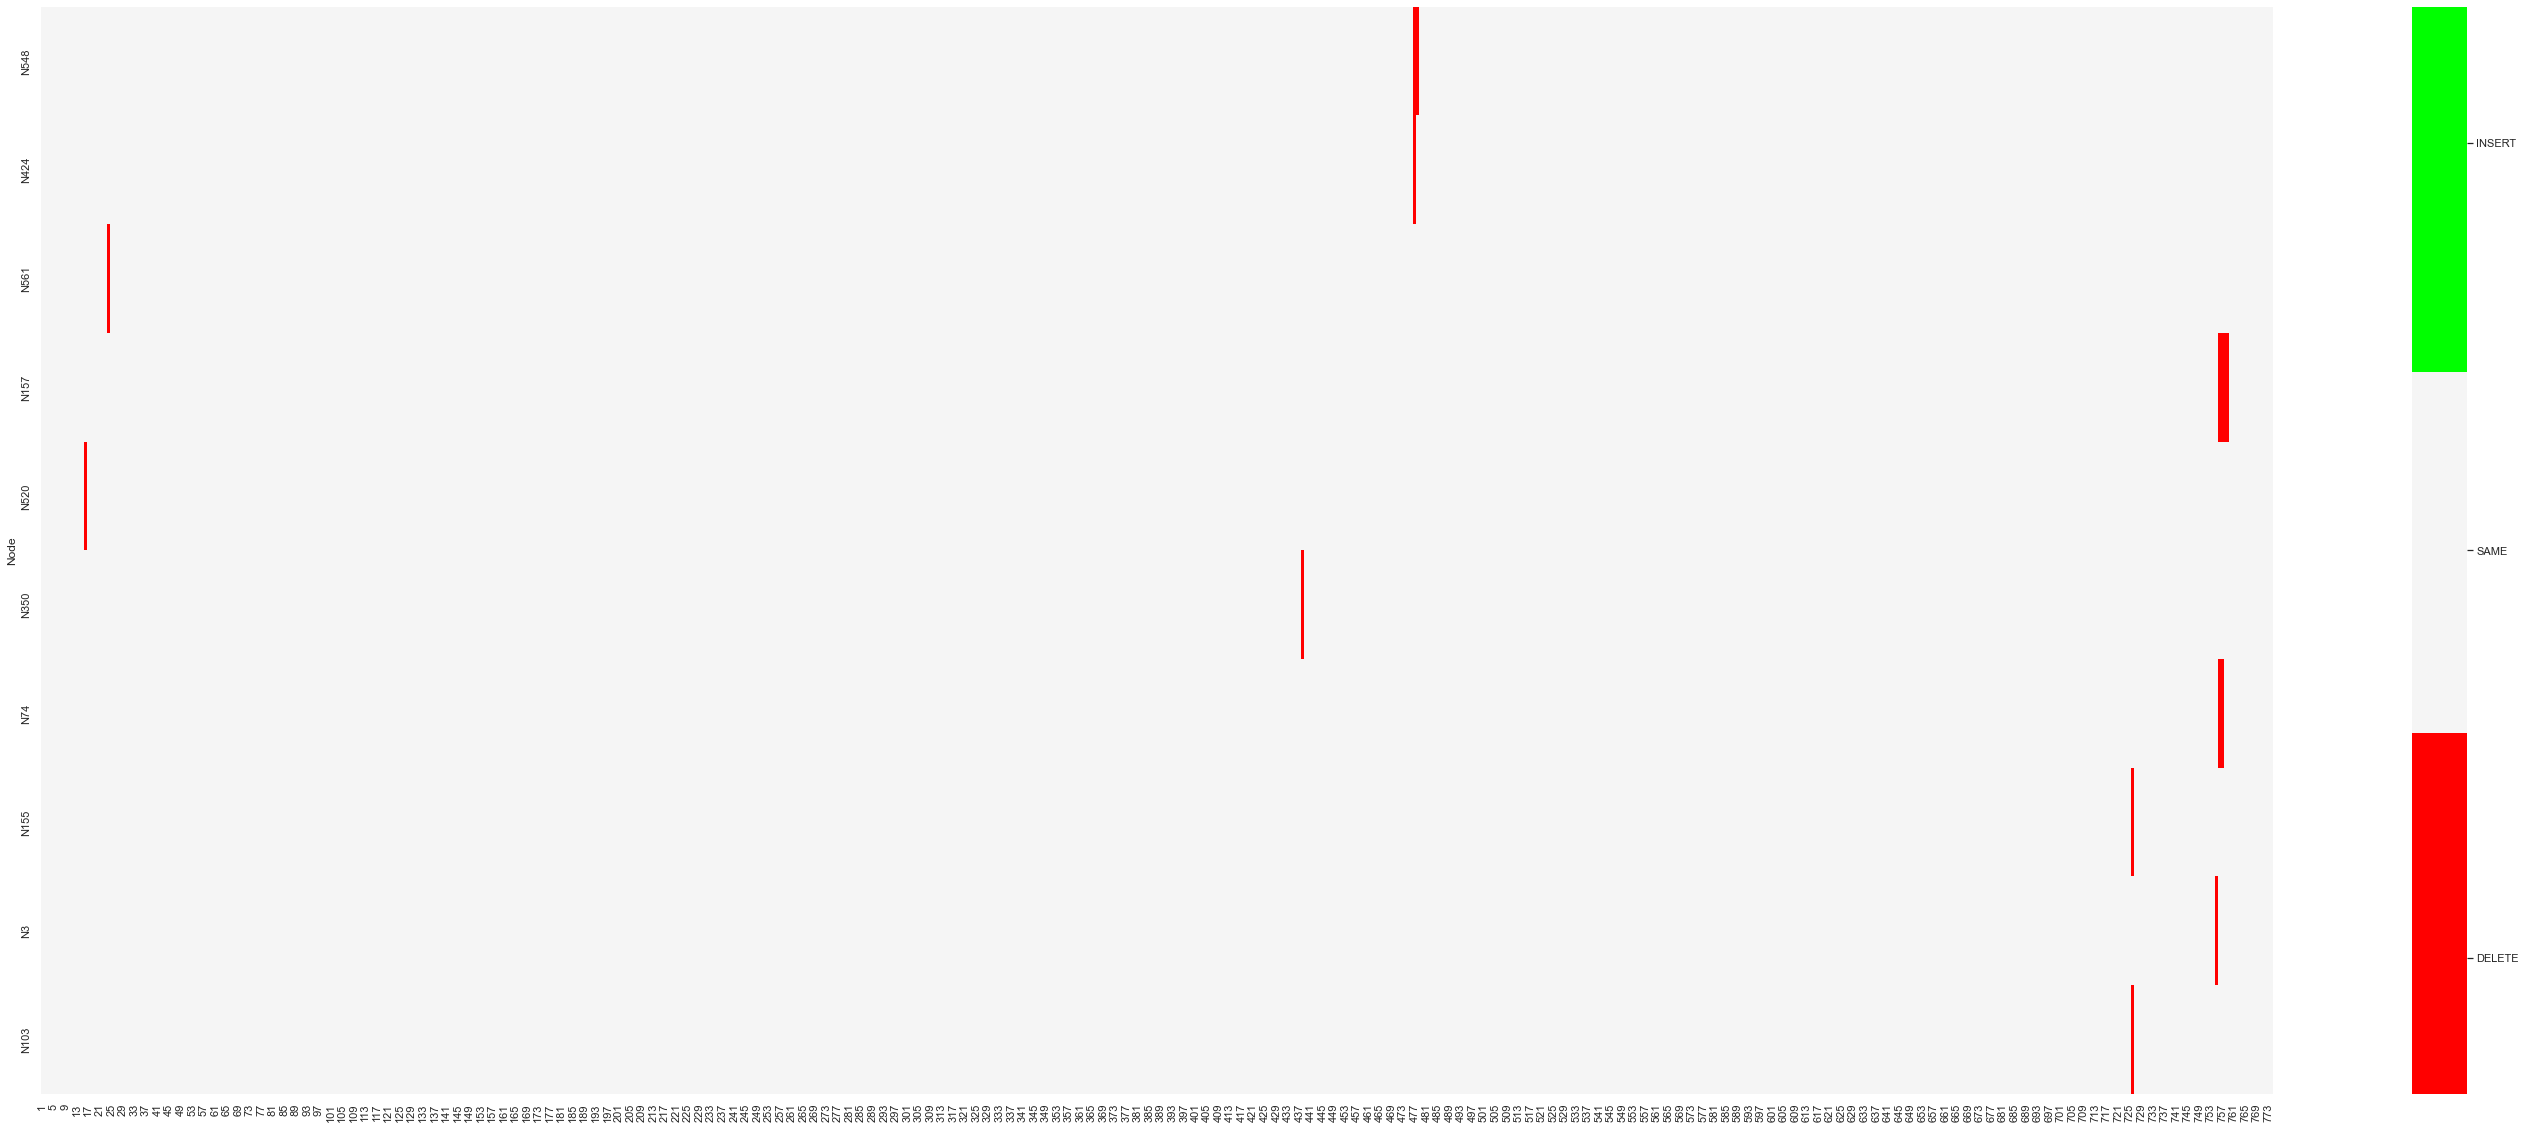

In [57]:
asrtree.visualise_changed_nodes()